# Security Prediction

We look at SPY and forecast its value. We then compare the predictions by using them with simple trading strategies.

[Jump to the conclusion at the end](#Conclusion)

In [1]:
import tensorflow.contrib.learn as learn # bug workaround: import first

import numpy as np
import pandas as pd
from time import clock

# Disable any Xwindows backend
# import matplotlib
# matplotlib.use('Agg')

from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Interactive plots
# import mpld3
# mpld3.enable_notebook()

# Seaborn
import seaborn as sb

# Temporarily suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Profiling notebook perfomance
start_notebook = clock()

# Data Overview

In [2]:
# Import data

import quandl
symbol = 'SPY'

df = quandl.get('GOOG/NYSE_' + symbol)['Close'].to_frame(name = symbol)

In [3]:
df.head()

,SPY
Date,
1997-08-21,92.59
1997-08-22,92.56
1997-08-25,92.22
1997-08-26,90.86
1997-08-27,91.41


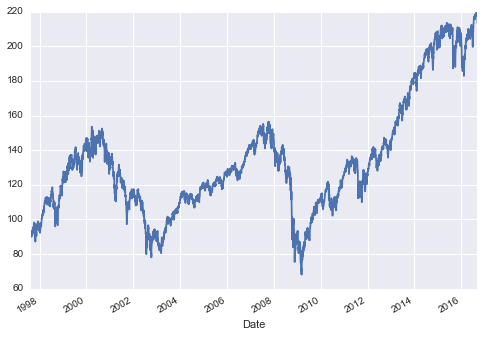

In [4]:
# Let's take a quick look
df[symbol].plot()

# plt.yscale('log')
plt.gcf().savefig('figures/preprocessed.png', bbox_inches = 'tight')
plt.show()

In [5]:
# Extract hour, month and year
df['hour'] = df.index.hour
df['month'] = df.index.month
df['year'] = df.index.year
# Which day of the week is this?
df['dow'] = df.index.dayofweek
# Is this a weekend?
df['weekend'] = df.dow >= 5

Dates range from 1997-08-21 00:00:00 to 2016-09-09 00:00:00 covering 19.1 years


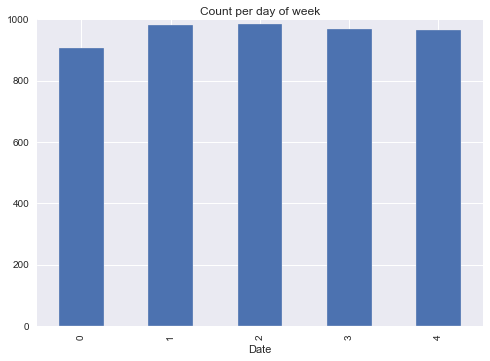

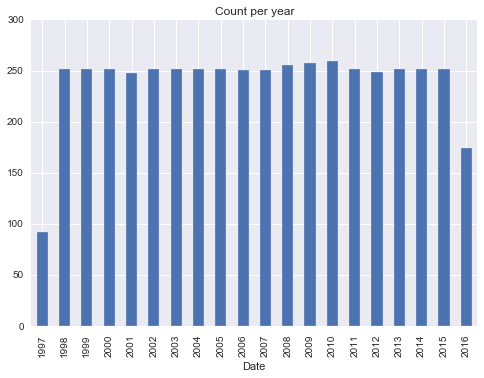

In [6]:
# Distribution of dates?
dates = pd.Series(df.index)

dates_min = pd.to_datetime(dates.min())
dates_max = pd.to_datetime(dates.max())
n_years = (dates_max - dates_min).days/365
# n_years = (dates_max - dates_min).to_timedelta64()
# n_years = n_years.astype('timedelta64[Y]')
print("Dates range from {} to {} covering {:.1f} years".format(dates.min(), dates.max(), n_years))

dates.groupby(dates.dt.dayofweek).count().plot(kind = "bar", title = "Count per day of week")
plt.show()
# There are no changes during the weekends

dates.gr-oupby(dates.dt.month).count().plot(kind = "bar", title = "Count per mount")
plt.show()

dates.groupby(dates.dt.year).count().plot(kind = "bar", title = "Count per year")
plt.show()

In [7]:
df_describe = df.describe()
df_describe

,SPY,hour,month,year,dow
count,4808.000000,4808.0,4808.000000,4808.000000,4808.000000
mean,133.792731,0.0,6.552413,2006.671797,2.020383
std,33.566387,0.0,3.426083,5.508661,1.401061
min,68.110000,0.0,1.000000,1997.000000,0.000000
25%,111.317500,0.0,4.000000,2002.000000,1.000000
50%,127.435000,0.0,7.000000,2007.000000,2.000000
75%,145.630000,0.0,10.000000,2011.000000,3.000000
max,219.090000,0.0,12.000000,2016.000000,4.000000


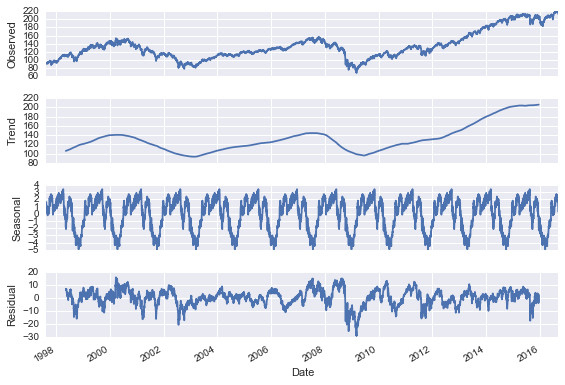

In [8]:
# Seasonal pattern?

def seasonal_plot(series):
    """
    Plot the seasonal trend.
    """
    
    from statsmodels.tsa.seasonal import seasonal_decompose

    # Yearly variation
    decomposition = seasonal_decompose(series, model = 'additive', freq = 365)

    decomposition.plot()
    plt.show()

seasonal_plot(df[symbol])

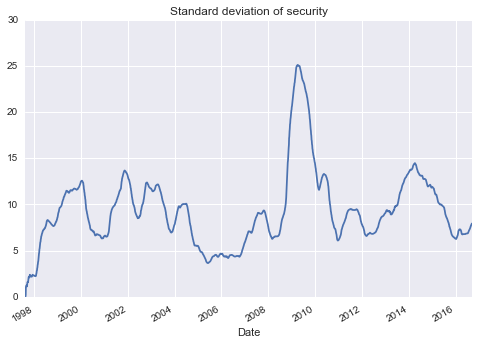

In [9]:
def rolling_stddev(series, window):
    """
    Return rolling standard deviation of series.
    """
    
    dates = series.index
    series_roll = series.rolling(window = window, min_periods = 1).std()

    return series_roll.loc[dates]

# Rolling std dev of difference
# df['rolling_stddev'] = rolling_stddev(df['meanless'])
# df['rolling_stddev'] = rolling_stddev(df['security'], window = 365*24*60)
# df['rolling_stddev'].plot()

security_stddev = rolling_stddev(df[symbol], 365)

# security_stddev = rolling_stddev(meanless_subsampled, 365)
security_stddev.plot(title = "Standard deviation of security")

plt.show()

The rolling means are important, so we can add different mean window to the data frame. We could use them as features for prediction, or as part of an [ARIMA model](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/).

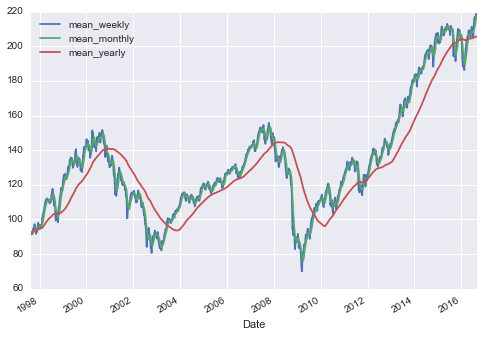

In [10]:
def rolling_mean(series, window):
    """
    Return rolling mean of series. 
    NOTE Shift by 1 to avoid including current value in prediction.
    """

    dates = series.index
    series_roll = series.shift(1).rolling(window = window, min_periods = 1).mean()

    return series_roll.loc[dates]

# We attach a few rolling means to the data frame
# We shift by one to avoid using the current value (for predic)
df['mean_weekly'] = rolling_mean(df[symbol], 7)
df['mean_monthly'] = rolling_mean(df[symbol], 30)
df['mean_yearly'] = rolling_mean(df[symbol], 365)

df[['mean_weekly', 'mean_monthly', 'mean_yearly']].plot()
plt.show()

Let's remove the mean and see what the rest looks like.

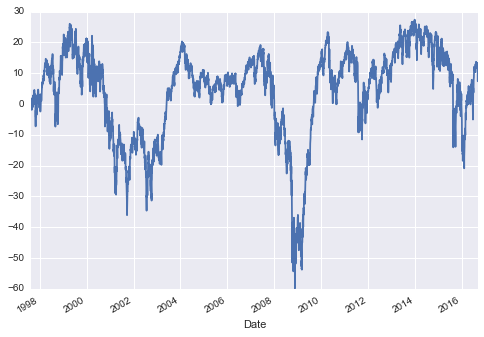

In [11]:
# Rolling mean

security_mean = rolling_mean(df[symbol], 365)

# security_mean.plot()
# plt.show()

meanless_subsampled = df[symbol] - security_mean
meanless_subsampled.plot()

plt.show()

In [12]:
# Let's also look at the frequency spectrum of this in case something comes up.

def fourier_plot(series, amplitude = None):
    """
    Plot the frequency spectrum of the time series.
    """
    
    n = len(series)
    sp = np.fft.fft(series)
    freq = np.fft.fftfreq(n)

    plt.plot(freq, sp.real, label = 'Re')
    plt.plot(freq, sp.imag, label = 'Im')
    
    plt.legend()
    if amplitude is not None:
        plt.ylim(-amplitude, amplitude)
        
    plt.show()

fourier_plot(meanless_subsampled, 5000)

# Derivative
Let's see how the derivative changes.

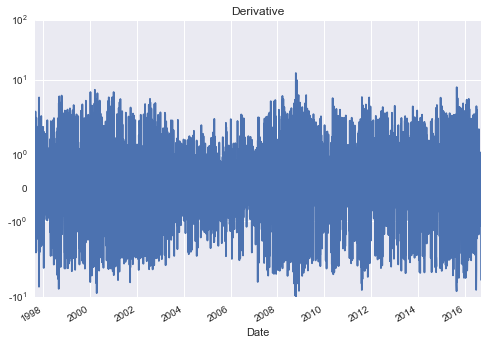

In [13]:
df['derivative'] = df[symbol].diff()
df['derivative'].plot(title = "Derivative")

plt.yscale('symlog')
plt.show()

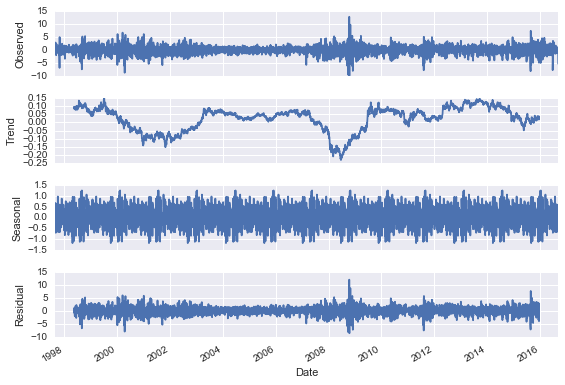

In [14]:
# Seasonal pattern?
deriv = df['derivative'].fillna(method = 'pad').fillna(method = 'bfill')
seasonal_plot(deriv)

We look at rolling means to see if the trend observed above can be discerned with different windows.

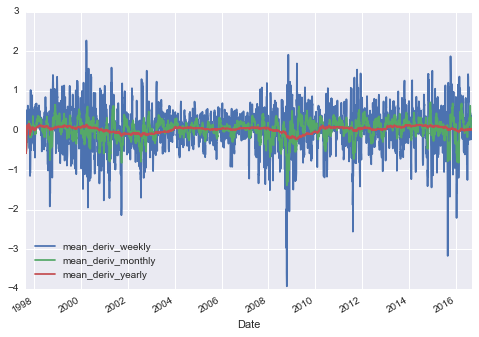

In [15]:
# We attach a few rolling means to the data frame
df['mean_deriv_weekly'] = rolling_mean(df['derivative'], 7)
df['mean_deriv_monthly'] = rolling_mean(df['derivative'], 30)
df['mean_deriv_yearly'] = rolling_mean(df['derivative'], 365)

df[['mean_deriv_weekly', 'mean_deriv_monthly', 'mean_deriv_yearly']].plot()
# plt.yscale('symlog')
plt.show()

We could consider predicting the derivative directly instead of the value of the security (and use the predicted derivative as the basis of a trading strategy).

# Strategy Backtesting

We use a simple framework from [here](https://www.quantstart.com/articles/Research-Backtesting-Environments-in-Python-with-pandas) to test simple strategies based on the forecast we develop. The framework assumes we have a time series of signal to buy, sell, or keep. For now, we do the simple strategy of buying/selling a few shares at a time, whenever the signal is &plusmn;1. The decisions must be based on the history of the security before the current time.

In [16]:
def backtest_portfolio(bars, signals, initial_capital = 100000.0, get_portfolio = False):
    """
    Create a system that purchases n 
    of a particular symbol upon a long/short signal, 
    assuming the market price of a bar.
    
    The portfolio is constructed from the positions DataFrame 
    by assuming the ability to trade at the precise market open price
    of each bar (unrealistic!). 

    In addition, there are zero transaction costs 
    and cash can be immediately borrowed for shorting 
    (no margin posting or interest requirements). 
    """
    
    index = bars.index

    # Create a 'positions' Series that simply longs or shorts n of the particular symbol 
    # based on the forecast signals of {1, 0, -1} from the signals DataFrame.
    n = 1
    signals = signals.fillna(0.)
    positions = n * signals
    
    bars = bars.values.ravel()
    positions = positions.values.ravel()
    
    # Calculate the total of cash and the holdings (market price of each position per bar), 
    # in order to generate an equity curve ('total') and a set of bar-based returns ('returns').
    holdings = positions * bars # Price of current operation
    cash = initial_capital - holdings.cumsum() # Cash available
    total = cash.ravel() + positions.ravel().cumsum() * bars.ravel() # Total value
            
    # Return the return on initial investement from between the beginning and the end
    V0 = initial_capital
    Vf = total[-1]
    pct = (Vf - V0)/V0
    
    if not get_portfolio:
        # Return the return on initial investment
        return pct
    else:            
        # Return the portfolio object to be used elsewhere.
        pf = pd.DataFrame(index = index)
        pf['positions'] = positions
        pf['signals'] = signals
        pf['holdings'] = holdings
        pf['cash'] = cash
        pf['total'] = total
        pf['returns'] = pf['total'].pct_change() # Percent change for each step
        
        return pct, pf

We implement a few simple strategies based on difference between shifted or predicted values. For now, we buy/sell a fix number of shares, but we could buy/sell signal proportinally to the (scaled) difference.

In [17]:
def strategy_with_forecast(outcome, predict):
    """
    If current prediction higher than yesterday's value, buy. If lower, sell.
    """
    
    index = outcome.index

    # NOTE memory error when not using values and ravel
    predict = np.array(predict).ravel()
    outcome_shifted = outcome.shift(1).values.ravel()
    signal = np.sign(predict - outcome_shifted)
    
    signal = pd.Series(signal.ravel(), index = index)

    # If current prediction higher than yesterday's prediction, buy. If lower, sell.
    # predict = pd.Series(predict, index = outcome.index)
    # signal = np.sign(predict - predict.shift(1))
    
    # Act proportionally to the difference
    # FIXME fit/transform on train/test
    
    # from sklearn.preprocessing import StandardScaler
    # scaler = StandardScaler()
    # signal = scaler.fit_transform(predict - outcome.shift(1))
    # signal = round(signal)
    
    return signal

def strategy_with_recent_history(outcome):
    """
    If going up in the last two days, buy. If going down, sell.
    """
    
    signal = np.sign(outcome.shift(1) - outcome.shift(2))
    
    # Act proportionally to the difference
    # FIXME fit/transform on train/test
    
    # from sklearn.preprocessing import StandardScaler
    # scaler = StandardScaler()
    # signal = scaler.fit_transform(outcome.shift(1) - outcome.shift(2))
    # signal = round(signal)
    
    return signal

def backtest_strategy_passive(outcome, initial_capital = 100000.0):
    """
    Buy as much as possible at the beginning, sell everything at the end.
    """
        
    V0 = outcome.ix[ 0]
    Vf = outcome.ix[-1]
    
    pct = (Vf - V0) / V0
    # final = initial_capital * pct
    
    return pct

We test the backtestings on the data, and see what is yielded.

In [18]:
values = df[symbol]
# values = df[symbol].resample('1D').mean().pad()

# Passive strategy
return_final = backtest_strategy_passive(values)
print("Return from passive strategy: {:.5f}".format(return_final))

# Strategy with recent history
signals = strategy_with_recent_history(values)
return_final = backtest_portfolio(values, signals)
print("Return from strategy with recent history: {:.5f}".format(return_final))

# Random strategy
signals = pd.Series(np.sign(np.random.randn(len(signals))), index = values.index)
return_final = backtest_portfolio(values, signals)
print("Return from random strategy: {:.5f}".format(return_final))

Return from passive strategy: 1.30349
Return from strategy with recent history: 0.21238
Return from random strategy: 0.01034


For further comparison, we implement a moving average crossover similar to [here](https://www.quantstart.com/articles/Backtesting-a-Moving-Average-Crossover-in-Python-with-pandas). We buy/sell when the short moving average crosses the long moving average.

In [19]:
def strategy_moving_average_crossover(bars, short_window = 100, long_window = 400):
    """    
    Return the DataFrame of symbols containing the signals to go long, short or hold (1, -1 or 0).

    Requires:
    bars - A DataFrame of bars for the above symbol.
    short_window - Lookback period for short moving average.
    long_window - Lookback period for long moving average.
    """

    signals = pd.DataFrame(index = bars.index)
    signals['invested'] = 0.

    # Create the set of short and long simple moving averages over the respective periods
    signals['short_mavg'] = pd.rolling_mean(bars, short_window, min_periods = 1)
    signals['long_mavg'] = pd.rolling_mean(bars, long_window, min_periods = 1)

    # Assign 1. when the short moving average is above the long moving average (else 0.)
    signals['invested'] = np.where(signals['short_mavg'] > signals['long_mavg'], 1., 0.)
    # Wait a little before investing
    signals['invested'][:long_window] = 0.
    
    # Take the difference in order to generate buy/sell signal
    signals['signal'] = signals['invested'].diff()

    return signals['signal']

In [20]:
# Create a Moving Average Cross Strategy instance with a short moving
# average window of 100 days and a long window of 400 days
signals = strategy_moving_average_crossover(values, short_window = 100, long_window = 400)

# Create a portfolio of AAPL, with $100,000 initial capital
return_final = backtest_portfolio(values, signals)
print("Return from moving average crossover strategy: {:.5f}".format(return_final))

Return from moving average crossover strategy: 0.00121


# Forecasting

We first need to select the features we want to use. We might want to use automated feature selection technique such as offered by [sklearn](http://scikit-learn.org/stable/modules/feature_selection.html).

In [21]:
# Attach past/future values to given day and time

# Given n_past values, predict the next n_future values.
n_past = 5
n_future = 1

def columns_shift(df, col, r):
    """
    Make shifted copies of series for each shift in in range.
    """
    
    dates = df.index
    
    # Upsample
    # df_resampled = df[col].resample('1T').pad().to_frame(col)
    df_resampled = df # to save memory
    
    # Create new columns
    for i in r:
        epoch = 'past' if i < 0 else 'future'
        df_resampled[col + '_' + epoch + '_' + str(abs(i))] = df_resampled[col].shift(-i)
    
    # Pick only rows that were in the original data frame, and merge back
    new_cols = df_resampled.ix[dates, :].drop(col, axis = 1)
    df[new_cols.columns] = new_cols
    # return pd.concat([df, new_cols], axis = 1)
    return df

# Drop prior columns
# cols = [c for c in df.columns if c.lower()[:len('security_past_')] == 'security_past_']
# df.drop(cols, axis = 1, inplace = True)

# Create columns for past/future values (0 shift is not past)
df = columns_shift(df, symbol, range(-n_past, n_future))

# Create columns for past derivatives
df = columns_shift(df, 'derivative', range(-n_past, -1))

# Check out the table
# df.head()

In [22]:
df.dropna(inplace = True) # Some models don't work with missing values

# Select columns used as feature and target for machine learning
target_columns = [col for col in df.columns if '_future_' in col]

# feature = df[feature_columns]
feature = df.drop(target_columns + [symbol, 'derivative'], axis = 1)
target = df[target_columns]

# The features and targets are:
print("Features: {}".format(list(feature.columns)))
print("Targets: {}".format(list(target.columns)))

Features: ['hour', 'month', 'year', 'dow', 'weekend', 'mean_weekly', 'mean_monthly', 'mean_yearly', 'mean_deriv_weekly', 'mean_deriv_monthly', 'mean_deriv_yearly', 'SPY_past_5', 'SPY_past_4', 'SPY_past_3', 'SPY_past_2', 'SPY_past_1', 'derivative_past_5', 'derivative_past_4', 'derivative_past_3', 'derivative_past_2']
Targets: ['SPY_future_0']


Let's hold out the last year as test set.

In [23]:
def split_train_test(feature, target, cutoff_test = '2015-01-01'):
    """
    Divide features and targets into train and test
    """

    ind_test = df.index >= cutoff_test
    feature_test = feature[ind_test]
    target_test = target[ind_test]

    ind_train = ~ind_test
    feature_train = feature[ind_train]
    target_train = target[ind_train]
    
    return feature_train, feature_test, target_train, target_test

# Apply split
feature_train, feature_test, target_train, target_test = split_train_test(feature, target)

We can try adding very many features, and then running an automated feature selection. Reducing the number of features might reduce high frequency oscillations in the predictions.

In [24]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

# LassoCV since L1 norm promotes sparsity of features
clf = LassoCV()
sfm = SelectFromModel(clf, threshold = 1e-5)
# sfm = SelectFromModel(clf, threshold = "mean")
sfm.fit(feature_train, target_train)
# NOTE had to disable mkl as discussed here: https://github.com/BVLC/caffe/issues/3884

feature_kept = feature.columns[sfm.get_support()]
print("Features: {}".format(feature_kept))

/home/vincent/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Features: Index(['mean_weekly', 'mean_monthly', 'SPY_past_4', 'SPY_past_2',
       'SPY_past_1'],
      dtype='object')


Let's try to bring this down to two features, and plot, as illustrated [here](http://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_boston.html#example-feature-selection-plot-select-from-model-boston-py).

Features for threshold 0.00801: Index(['SPY_past_2', 'SPY_past_1'], dtype='object')


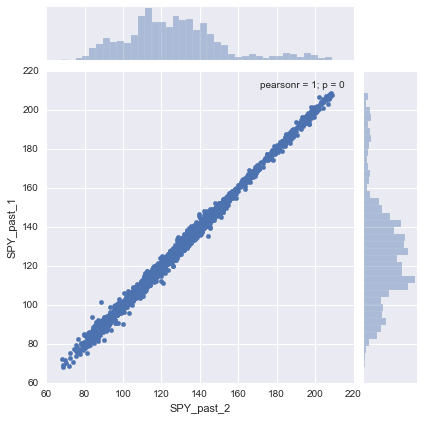

In [25]:
n_features = len(feature_kept)

# Reset the threshold till the number of features equals two.
# The attribute can be set directly instead of repeatedly fitting the metatransformer.
X = feature_train
while n_features > 2:
    sfm.threshold += 10e-4
    X_transform = sfm.transform(X)
    n_features = X_transform.shape[1]

feature_kept = feature.columns[sfm.get_support()]
print("Features for threshold {}: {}".format(sfm.threshold, feature_kept))

try:
    X_transform_df = pd.DataFrame(X_transform, columns = feature_kept)
    sb.jointplot(*feature_kept, X_transform_df)  
except IndexError:
    pass

In [26]:
# Keep only most important features
feature_train = pd.DataFrame(sfm.transform(feature_train), 
                             columns = feature_kept, index = feature_train.index)
feature_test = pd.DataFrame(sfm.transform(feature_test), 
                            columns = feature_kept, index = feature_test.index)

We can first try a linear regression. We could have also tried a linear model with built-in feature selection like [Lasso or ElasticNet](http://scikit-learn.org/stable/modules/linear_model.html). 

In [27]:
# Linear regression
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

# Quick cross validation
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(reg, feature, target, cv = 5)
print("R^2 during CV: {:.2f} +/- {:.2f}".format(scores.mean(), scores.std() * 2))

R^2 during CV: 0.99 +/- 0.00


To evaluate our predictions, we introduce the Mean Absolute Percentage Error (MAPE), as often used in forecasting.

In [28]:
def mape(outcome, predict):
    """
    Compute Mean Absolute Percentage Error (MAPE) score. Positive, but lower is better.
    """
    
    outcome = np.array(outcome).ravel()
    predict = np.array(predict).ravel()
    
    # Get only the NONZERO or NON-NAN elements
    EPSILON = pow(10, -5)
    idx = (np.abs(outcome) > EPSILON) | (~np.isnan(outcome)) | (~np.isnan(predict))
    
    # Extract those elements
    outcome = outcome[np.where(idx)]
    predict = predict[np.where(idx)]
    
    return np.mean(np.abs((outcome - predict) / outcome))

To evaluate, we also use the portfolio return obtained through the strategy using the predictions from the model.

In [29]:
def portfolio_return_score(actual, predictions, get_portfolio = False):
    """
    Compute returns from trading strategy with forecast.
    """
    
    # pred_test_pf = list(zip(*self.pred_test))[0]
    # target_test_pf = self.target_test.ix[:,0]

    signals = strategy_with_forecast(actual, predictions)
    return backtest_portfolio(actual, signals, get_portfolio = get_portfolio)  

We introduce here a class for fitting an plotting a given model. We also output a few metrics [supported by sklearn](http://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) along the mape score to evaluate the fit on the test set.

In [30]:
# Function for fitting and plotting
class Regression():
    
    def __init__(self, reg, feature_train, feature_test, target_train, target_test, **kwargs):
        
        self.reg = reg
        self.feature_train = feature_train
        self.feature_test = feature_test
        self.target_train = target_train.ix[:,0]
        self.target_test = target_test.ix[:,0]
        
        # Fit
        self.fit(self.feature_train, self.target_train, **kwargs)
        
        # Predictions
        self.pred_train = self.predict(feature_train)
        self.pred_test = self.predict(feature_test)
        
        # Evaluate
        self.performance()
    
    def fit(self, feature, target, **kwargs):
        """
        Train model.
        """
        
        start = clock()
        self.reg.fit(feature, target, **kwargs)
        print("Fit in {:.0f} seconds".format(clock() - start))
    
    def predict(self, feature):
        """
        Predict.
        """
        
        pred = self.reg.predict(feature)
        
        # FIXME ravel works for single output only
        return pd.Series(pred.ravel(), index = feature.index)
    
    def performance(self):
        """
        Output various scores to evaluate model.
        """
        
        target_test = self.target_test
        pred_test = self.pred_test
        
        scores = {}
    
        scores['MAPE'] = self.mape = mape(target_test, pred_test)
        
        scores['Portfolio Return'], self.portfolio = \
            portfolio_return_score(target_test, pred_test, get_portfolio = True)
    
        from sklearn.metrics import r2_score
        scores['R2'] = self.r2 = r2_score(target_test, pred_test)
    
        from sklearn.metrics import explained_variance_score
        scores['Explained Variance'] = self.evs = explained_variance_score(target_test, pred_test)

        from sklearn.metrics import mean_squared_error
        scores['Mean Square Error'] = self.mse = mean_squared_error(target_test, pred_test)
        scores['Root Mean Square Error'] = self.rmse = np.sqrt(self.mse)
    
        from sklearn.metrics import median_absolute_error
        scores['Median Absolute Error'] = self.mae = median_absolute_error(target_test, pred_test)
        
        print(pd.Series(scores, name = 'Scores'))
        
    def plot_prediction(self, filename = None):
        """
        Plot predicted versus actual.
        """
        
        def pack_pred(indices, target, pred):
            """
            Pack in one data frame the target and the predictions.
            """
        
            df = pd.DataFrame(index = indices)
            df['predicted'] = pred
            df['security'] = target
        
            return df[['predicted', 'security']]
        
        # Plot only predictions on test set
        df_test = pack_pred(self.feature_test.index, self.target_test, self.pred_test)
        df_test.plot()
        
        # Add shaded region for error corresponding to training error
        err_graph = self.rmse
        plt.fill_between(df_test.index,
                         df_test.predicted - err_graph, df_test.predicted + err_graph, alpha = 0.2)
        
        if filename is not None:
            # Grab figure before show clear, then clear
            plt.gcf().savefig(filename, bbox_inches = 'tight')
        
        plt.show()
    
    def plot_residual(self):
        """
        Plot residual
        """
        
        # residuals = np.square(self.target_test - self.pred_test)
        residuals = (self.target_test - self.pred_test)**2  # NOTE may cause kernel crash
        print("Max residual at {}".format(residuals.idxmax()))
        
        residuals.plot(title = "Residual")
        # plt.yscale('log')
        plt.show()
        
    def plot_portfolio(self, filename = None):
        """
        Plot portfolio.
        """
        
        # holdings_pos = self.portfolio.ix[self.portfolio['holdings'] > 0, 'holdings'].abs()
        # holdings_neg = self.portfolio.ix[self.portfolio['holdings'] < 0, 'holdings'].abs()
        # holdings_pos.plot(label = 'Positive Holdings')
        # holdings_neg.plot(label = 'Negative Holdings')
            
        # self.portfolio['cash'].plot(title = 'Available Cash)
        self.portfolio['total'].plot(title = 'Portfolio Total Value')
        
        if filename is not None:
            # Grabs figure before show clears
            plt.gcf().savefig(filename, bbox_inches = 'tight')
            
        plt.show()

Fit in 0 seconds
Explained Variance        0.934027
MAPE                      0.006836
Mean Square Error         3.665058
Median Absolute Error     0.955399
Portfolio Return         -0.003778
R2                        0.933992
Root Mean Square Error    1.914434
Name: Scores, dtype: float64


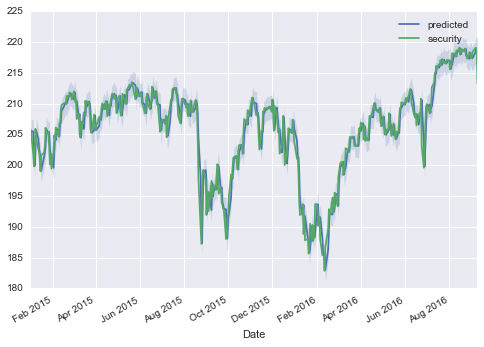

In [31]:
regression_linear = Regression(reg, feature_train, feature_test, target_train, target_test)
regression_linear.plot_prediction(filename = 'figures/prediction.png')

Let's take a look at the residuals.

Max residual at 2015-08-24 00:00:00


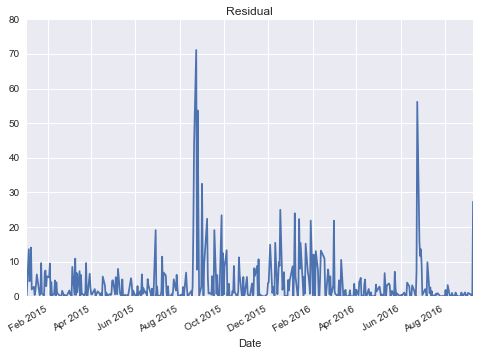

In [32]:
regression_linear.plot_residual()

Let's look at which feature has a larger effect on the output.

Coefficients: [ 0.05828046  0.94106108]
Intercept: 0.11143554825470403


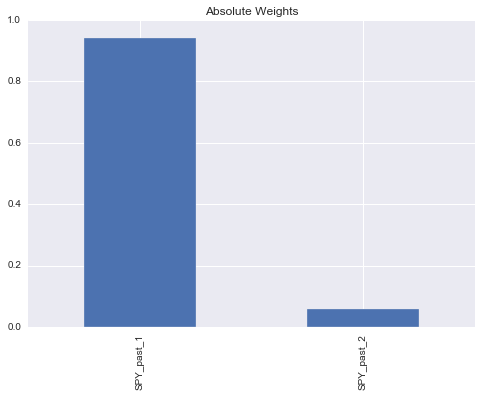

In [33]:
# Peek at coefficients
print("Coefficients: {}".format(reg.coef_))
print("Intercept: {}".format(reg.intercept_))

coef = pd.DataFrame(abs(reg.coef_), index = feature_train.columns)
coef = coef.sort_values(by=[0], ascending=[False])

coef.plot(kind = 'bar', legend = False, title = 'Absolute Weights')
plt.show()

We now use the forecast to test the trading strategy mentioned before.

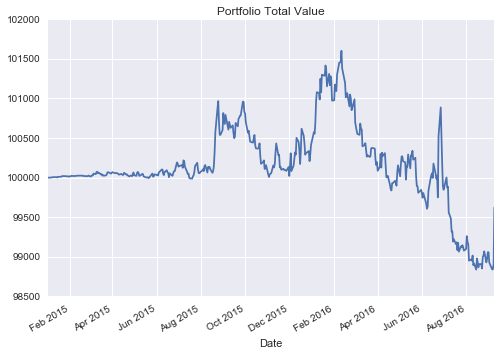

In [34]:
regression_linear.plot_portfolio(filename = 'figures/returns.png')

For comparison, we look at the other strategies implemented.

In [35]:
target_test_pf = target_test.ix[:,0]

# Passive strategy

return_final = backtest_strategy_passive(target_test_pf)
print("Return from passive strategy: {:.5f}".format(return_final))

# Strategy with recent history

signals = strategy_with_recent_history(target_test_pf)
return_final = backtest_portfolio(target_test_pf, signals)
print("Return from strategy with recent history: {:.5f}".format(return_final))

# Create a Moving Average Cross Strategy

signals = strategy_moving_average_crossover(target_test_pf, short_window = 100, long_window = 400)
return_final = backtest_portfolio(target_test_pf, signals)
print("Return from moving average crossover strategy: {:.5f}".format(return_final))

Return from passive strategy: 0.03821
Return from strategy with recent history: -0.00127
Return from moving average crossover strategy: -0.00003


In [36]:
target_test_pf.head()

Date
2015-01-02    205.43
2015-01-05    201.72
2015-01-06    199.82
2015-01-07    202.31
2015-01-08    205.90
Name: SPY_future_0, dtype: float64

## Grid Search with ElasticNet

Let's see if we can improve the return of the portfolio by tweak parameters of our regression using cross-validation grid search from [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html). [Here](http://scikit-learn.org/stable/modules/grid_search.html) are tips on using grid search. We use elastic net, which is similar to a linear regression with an extra $L^1$ regularization term allowing for some built-in automatic feature selection.

In [37]:
from sklearn.linear_model import ElasticNet
reg = ElasticNet()

# List all parameters
# print(reg.get_params().keys())

parameters = {
    'l1_ratio': [0.5, 1.],
    'alpha': [0.5, 1.],
}

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] l1_ratio=0.5, alpha=0.5 .........................................
[CV] ............... l1_ratio=0.5, alpha=0.5, score=-0.009953 -   0.1s
[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    0.1s
[CV] l1_ratio=0.5, alpha=0.5 .........................................
[CV] ............... l1_ratio=0.5, alpha=0.5, score=-0.113861 -   0.1s
[Parallel(n_jobs=1)]: Done   2 tasks       | elapsed:    0.1s
[CV] l1_ratio=0.5, alpha=0.5 .........................................
[CV] ............... l1_ratio=0.5, alpha=0.5, score=-0.171585 -   0.1s
[Parallel(n_jobs=1)]: Done   3 tasks       | elapsed:    0.2s
[CV] l1_ratio=1.0, alpha=0.5 .........................................
[CV] ............... l1_ratio=1.0, alpha=0.5, score=-0.014670 -   0.1s
[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:    0.3s
[CV] l1_ratio=1.0, alpha=0.5 .........................................
[CV] ............... l1_ratio=1.0, alpha=0.5, score=-

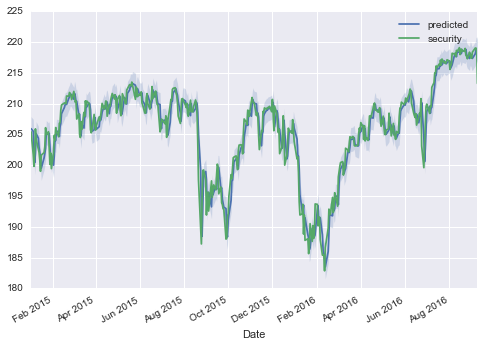

Max residual at 2015-08-24 00:00:00


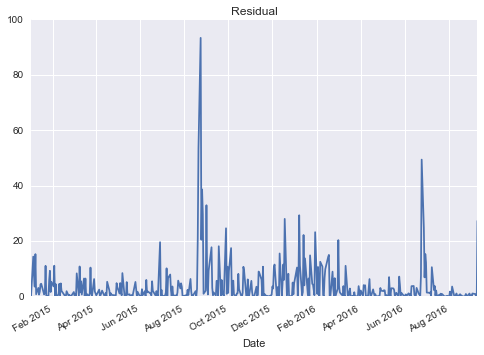

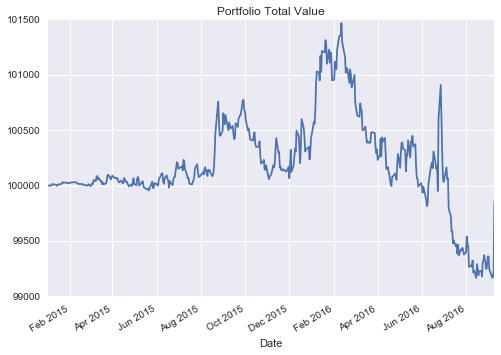

Best portfolio return: -0.09234
Best parameters: {'l1_ratio': 0.5, 'alpha': 1.0}


In [38]:
# Wrap the portfolio return score function for use with grid search
from sklearn.metrics import make_scorer
portfolio_return_scorer = make_scorer(portfolio_return_score, greater_is_better = True)

# Grid search for the regression
from sklearn.grid_search import GridSearchCV
grid = GridSearchCV(reg, parameters, scoring = portfolio_return_scorer, verbose = 100)

# Reset features to undo the automated feature selection
feature_train, feature_test, target_train, target_test = split_train_test(feature, target)

regression_linear = Regression(grid, feature_train, feature_test, target_train, target_test)
regression_linear.plot_prediction()
regression_linear.plot_residual()
regression_linear.plot_portfolio()

# What are the parameters with the best score?
print("Best portfolio return: {:.5f}".format(grid.best_score_))
print("Best parameters: {}".format(grid.best_params_))

We see that the portfolio return depends heavily on the set on which it is computed. Grid search with cross-validation uses three different test sets with each sets resulting in very different results on each sets -- but hopefully this may help make the model more robust.

Let's look at the effect of each feature.

Coefficients: [ 0.          0.          0.         -0.          0.          0.05603579
  0.0036674  -0.          0.          0.          0.          0.          0.
  0.00568784  0.15685924  0.77654609 -0.          0.          0.         -0.        ]
Intercept: 0.18933534418678732


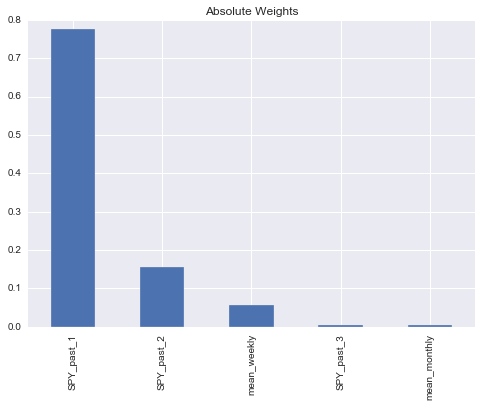

In [39]:
# Peek at coefficients
reg = grid.best_estimator_
print("Coefficients: {}".format(reg.coef_))
print("Intercept: {}".format(reg.intercept_))

coef = pd.DataFrame(abs(reg.coef_), index = feature_train.columns)
coef = coef.sort_values(by=[0], ascending=[False])

coef.ix[coef.ix[:,0] > 1e-5, :].plot(kind = 'bar', legend = False, title = 'Absolute Weights')
plt.show()

## Grid Search with XGBoost

We use [XGBoost Python API](http://xgboost.readthedocs.io/en/latest/python/python_api.html) with cross-validation grid search from [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html). [Here](http://scikit-learn.org/stable/modules/grid_search.html) are tips on using grid search; and [here](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) for tweaking XGBoost.
<img src="figures/gbdt.jpg">

In [40]:
# XGBoost
from xgboost import XGBRegressor
reg = XGBRegressor(silent = False, objective = 'reg:linear')

# List all parameters
# print(reg.get_params().keys())

parameters = {
    'n_estimators': [5, 10],
    'learning_rate': [0.1],
    # 'subsample': [0.1, 0.5],
    'subsample': [0.2],
    'colsample_bytree': [0.2], 
    # 'min_child_weight': [6], 
    'max_depth': [2, 4],
    # 'scale_pos_weight': [10],
    # 'gamma': [0], 
    # 'reg_alpha': [0], 
    # 'reg_lambda': [0.1]
}

We now run grid search with XGBoost.

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] learning_rate=0.1, subsample=0.2, n_estimators=5, max_depth=2, colsample_bytree=0.2 
[CV]  learning_rate=0.1, subsample=0.2, n_estimators=5, max_depth=2, colsample_bytree=0.2, score=0.245207 -   0.1s
[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    0.1s
[CV] learning_rate=0.1, subsample=0.2, n_estimators=5, max_depth=2, colsample_bytree=0.2 
[CV]  learning_rate=0.1, subsample=0.2, n_estimators=5, max_depth=2, colsample_bytree=0.2, score=0.608623 -   0.1s
[Parallel(n_jobs=1)]: Done   2 tasks       | elapsed:    0.1s
[CV] learning_rate=0.1, subsample=0.2, n_estimators=5, max_depth=2, colsample_bytree=0.2 
[CV]  learning_rate=0.1, subsample=0.2, n_estimators=5, max_depth=2, colsample_bytree=0.2, score=-0.941672 -   0.0s
[Parallel(n_jobs=1)]: Done   3 tasks       | elapsed:    0.1s
[CV] learning_rate=0.1, subsample=0.2, n_estimators=10, max_depth=2, colsample_bytree=0.2 
[CV]  learning_rate=0.1, subsample=0.2, n_estim

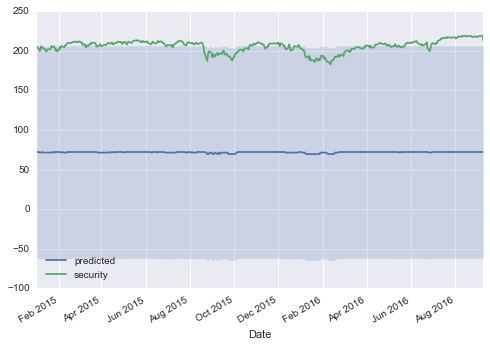

Max residual at 2016-08-15 00:00:00


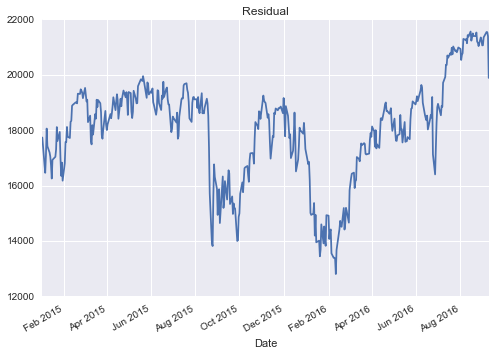

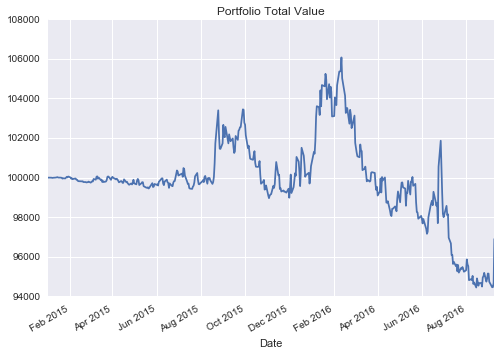

Best portfolio return: -0.02907
Best parameters: {'learning_rate': 0.1, 'subsample': 0.2, 'n_estimators': 5, 'max_depth': 2, 'colsample_bytree': 0.2}


In [41]:
# Grid search for the regression
from sklearn.grid_search import GridSearchCV
grid = GridSearchCV(reg, parameters, scoring = portfolio_return_scorer, verbose = 100)

# Reset features to undo the automated feature selection
feature_train, feature_test, target_train, target_test = split_train_test(feature, target)

regression_linear = Regression(grid, feature_train, feature_test, target_train, target_test)
regression_linear.plot_prediction()
regression_linear.plot_residual()
regression_linear.plot_portfolio()

# What are the parameters with the best score?
print("Best portfolio return: {:.5f}".format(grid.best_score_))
print("Best parameters: {}".format(grid.best_params_))

We extract the importance of each features according to XGBoost. [Here](https://www.kaggle.com/mmueller/liberty-mutual-group-property-inspection-prediction/xgb-feature-importance-python/code) is an example implementation of this.

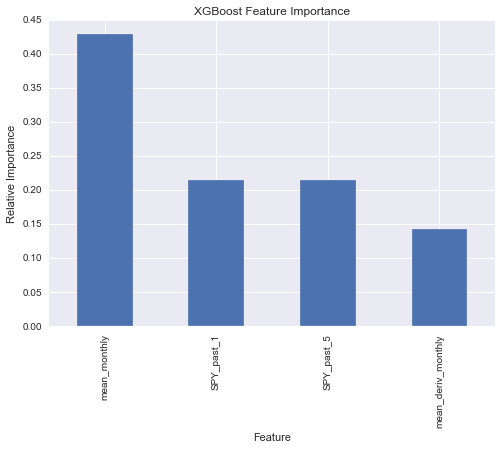

In [42]:
reg = grid.best_estimator_
importance = reg.booster().get_fscore()

import operator
importance = sorted(importance.items(), key = operator.itemgetter(1), reverse = True)

importance = pd.DataFrame(importance, columns = ['feature', 'fscore'])
importance['fscore'] = importance['fscore'] / importance['fscore'].sum()

importance.plot(kind = 'bar', x = 'feature', y = 'fscore', legend = False)
plt.title('XGBoost Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Relative Importance')
plt.show()

## Neural Networks

[TF Learn](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/learn/python/learn) provide a sklearn-like interface to Google's Tensor Flow for neural networks. See [here](https://github.com/tflearn/tflearn/blob/master/tutorials/intro/quickstart.md) for a quick start. The particular neural network here has 3 layer network with 10, 20 and 10 hidden units respectively. The optimizer does not work well with features of different scales, so we have to scale to zero mean and unit variance.

In [43]:
# Neural networks are sensitive to scaling
from sklearn.preprocessing import StandardScaler

preproc = StandardScaler()
feature_train.ix[:,:] = preproc.fit_transform(feature_train, target_train)
feature_test.ix[:,:] = preproc.transform(feature_test, target_test)

INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=20, default_value=None, dtype=tf.float32)
INFO:tensorflow:Restored model from log/dnn2/model.ckpt-2000-?????-of-00001
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Training steps [2000,2000)
INFO:tensorflow:Saving checkpoint for step 2000 to checkpoint: log/dnn2/model.ckpt.
INFO:tensorflow:Loss for final step: None.
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=20, default_value=None, dtype=tf.float32)
INFO:tensorflow:Loading model from checkpoint: log/dnn2/model.ckpt-2000-?????-of-00001.


Fit in 2 seconds


INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=20, default_value=None, dtype=tf.float32)
INFO:tensorflow:Loading model from checkpoint: log/dnn2/model.ckpt-2000-?????-of-00001.


Explained Variance         0.794513
MAPE                       0.012347
Mean Square Error         12.989294
Median Absolute Error      1.649843
Portfolio Return           0.008595
R2                         0.766063
Root Mean Square Error     3.604066
Name: Scores, dtype: float64


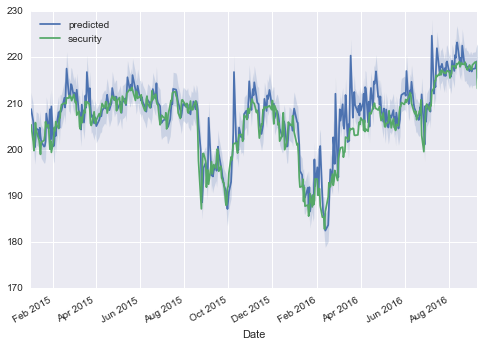

Max residual at 2016-02-26 00:00:00


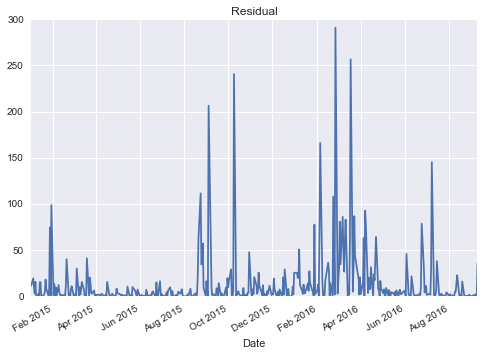

In [44]:
# In-depth logging
import logging
logging.getLogger().setLevel(logging.INFO)

# Deep neural network with tensor flow
import tensorflow.contrib.learn as learn

# reg = learn.LinearRegressor() # simpler model, for debugging
reg = learn.DNNRegressor(hidden_units = [10, 20, 10], model_dir = 'log/dnn2/')
# For detailed log, run: ~/.local/bin/tensorboard --logdir=log/dnn1/

# Parameters
batch_size = None # NOTE Default is None and yields feature_train.shape[0]
steps = 2000

# Train and test
regression_linear = Regression(reg, feature_train, feature_test, target_train, target_test, 
                               steps = steps, batch_size = batch_size)

# Plot
regression_linear.plot_prediction()
regression_linear.plot_residual()

In [45]:
# Compute number of epochs (number of times the optimizer ran through all the training set)

steps = reg.get_variable_value('global_step')
batch_size = feature_train.shape[0] if batch_size is None else batch_size

epoch = batch_size * steps / feature_train.shape[0]
print("Epochs: {:.2f}".format(epoch))

Epochs: 2000.00


Using the full interface of tensor flow would allow more fine tuning of many hyperparameters (but, if not for limited computational resources, the number of steps should also be increased). Here's the graph representation (obtained through tensorboard) of the neural network trained.
<img src="figures/dnn.png">

# Conclusion

We introduced various features like past values, past derivatives, rolling means for different windows, etc. Using automated feature selection (lasso in this case) allowed us to keep only the two most important features. We then applied a linear regression. Here is the values of the security and its predictions (with root mean square error band) tested on the last year of the data.

<img src="figures/prediction.png">

We then used this forecast in a simple minute-by-minute trading strategy: (1) if the predicted value is higher than the previous actual value, we buy a fix number of shares; (2) if lower, than we sell the same fix number; (3) otherwise, we do nothing. Here is a plot of the total value of the portfolio in time using the strategy using the forecast.

<img src="figures/returns.png">

In order to improve the portfolio return, we ran a grid search with cross-validation using the portfolio return as custom score to compare the various models. The grid search was applied to Elastic Net, but also to XGBoost. We also ran a simple neural network for comparison.

In [46]:
print("Notebook ran in {:.1f} minutes".format((clock() - start_notebook)/60))

Notebook ran in 0.6 minutes
